# Image Segmentation

* REDNet Fine Tuning
 - https://dambaekday.tistory.com/3
 - https://m.blog.naver.com/laonple/220985349467

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Package

In [2]:
import tensorflow as tf
import numpy as np

# I. Oxford_IIIT Pet Data_Set

> ## 1) 학습용 'Image'와 'Label' 다운로드

* 'Image'의 경계선과 내용, 외곽 3가지 분류 학습

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQKH0QP/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQKH0QP/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


* tfds 에러 시 사용

In [4]:
# !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets = oxford_iiit_pet:3.2.0

> ## 2) Data_Set Information

* features
 - image - shape=(None, None, 3)
 - label - num_claasses=37
 - segmentation_mask - shape=(None, None, 1)

* split
 - train : 3680
 - test : 3669

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

> ## 3) 'train', 'test' 데이터 수 저장

In [6]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

# II. load_image( )

> ## 1) 함수 정의

* 'image' and 'segmetation_mask'
* Resize : (128, 128) 
* Normalization

In [7]:
def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask = mask - 1
    
    return img, mask

> ## 2) 'train_dataset' and 'test_dataset' 정의

In [8]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

# III. 'image' and 'segmentation_mask' 확인

* 각 픽셀의 값을 중심부, 배경, 외곽선으로 분류 하는 문제
 * 중심부 : '1'
 * 배경 : '2'
 * 외곽선 : '3'

* mask의 'label'이 '0'부터 시작하도록 설정

0.3996089 0.00047392002


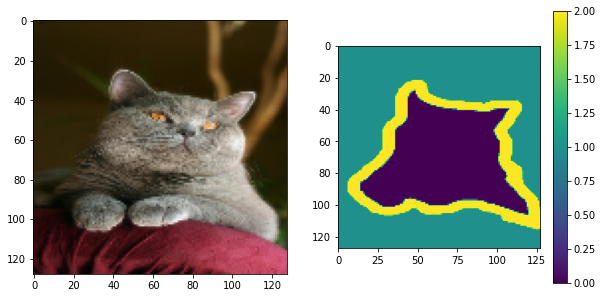

In [9]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1):
    plt.figure(figsize = (10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img[2])
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask[2], axis = 2))
    plt.colorbar()

    print(np.amax(img[1][2]), np.amin(img[1][2]))

# IV. REDNet Fine Tuning

> ## 1) 마지막 레이어 수정

* deconv_layers : 'softmax' Activation

In [10]:
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape = (None, None, 3))
    conv_layers.append(tf.keras.layers.Conv2D(3, 
                                              kernel_size = 3, 
                                              padding = 'same', 
                                              activation = 'relu'))

    for i in range(num_layers - 1):
        conv_layers.append(tf.keras.layers.Conv2D(64, 
                                                  kernel_size = 3, 
                                                  padding = 'same', 
                                                  activation = 'relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, 
                                                             kernel_size = 3, 
                                                             padding = 'same', 
                                                             activation = 'relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, 
                                                         kernel_size = 3, 
                                                         padding = 'same', 
                                                         activation = 'softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers - 1):
        x = conv_layers[i + 1](x)
        if i % 2 == 0:
            residual_layers.append(x)

    for i in range(num_layers - 1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x) 

    x = deconv_layers[-1](x)
    
    model = tf.keras.Model(inputs = inputs, outputs = x)
    return model

> ## 2) Model Compile

In [11]:
model = REDNet_segmentation(15)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 120분

In [12]:
%%time

history = model.fit(train_dataset,
                    epochs = 20,
                    steps_per_epoch = train_data_len // 16, 
                    validation_data = test_dataset, 
                    validation_steps = test_data_len)

Epoch 1/20
230/230 [==============================] - 357s 2s/step - loss: 0.8681 - accuracy: 0.5819 - val_loss: 0.8617 - val_accuracy: 0.5733
Epoch 2/20
230/230 [==============================] - 346s 2s/step - loss: 0.7556 - accuracy: 0.6372 - val_loss: 0.7182 - val_accuracy: 0.6804
Epoch 3/20
230/230 [==============================] - 346s 2s/step - loss: 0.6683 - accuracy: 0.7073 - val_loss: 0.6468 - val_accuracy: 0.7238
Epoch 4/20
230/230 [==============================] - 346s 2s/step - loss: 0.6252 - accuracy: 0.7316 - val_loss: 0.6258 - val_accuracy: 0.7337
Epoch 5/20
230/230 [==============================] - 346s 2s/step - loss: 0.5886 - accuracy: 0.7501 - val_loss: 0.5680 - val_accuracy: 0.7597
Epoch 6/20
230/230 [==============================] - 346s 2s/step - loss: 0.5640 - accuracy: 0.7612 - val_loss: 0.5570 - val_accuracy: 0.7661
Epoch 7/20
230/230 [==============================] - 345s 2s/step - loss: 0.5411 - accuracy: 0.7721 - val_loss: 0.5239 - val_accuracy: 0.7817

# V. Model Validation

> ## 1) 테스트 이미지 분할 확인

* 'image', 'segmentation_mask', 'learned_mask'

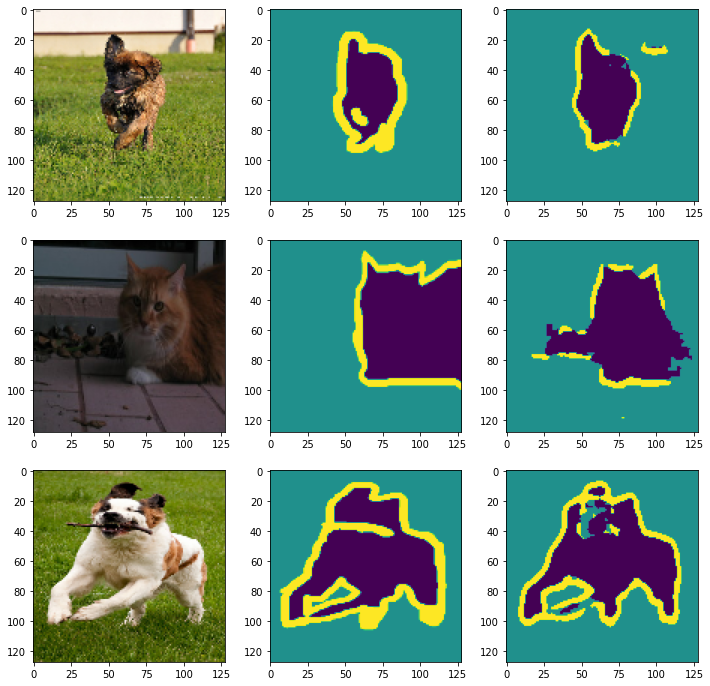

In [13]:
plt.figure(figsize = (12, 12))

for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3 + 1)
    plt.imshow(img[0])
    
    plt.subplot(3, 3, idx*3 + 2)
    plt.imshow(np.squeeze(mask[0], axis = 2))
    
    predict = tf.argmax(model.predict(img), axis = -1)
    plt.subplot(3, 3, idx*3 + 3)
    plt.imshow(np.squeeze(predict, axis = 0))

> ## 2) 테스트 이미지 분할 확인(원본)

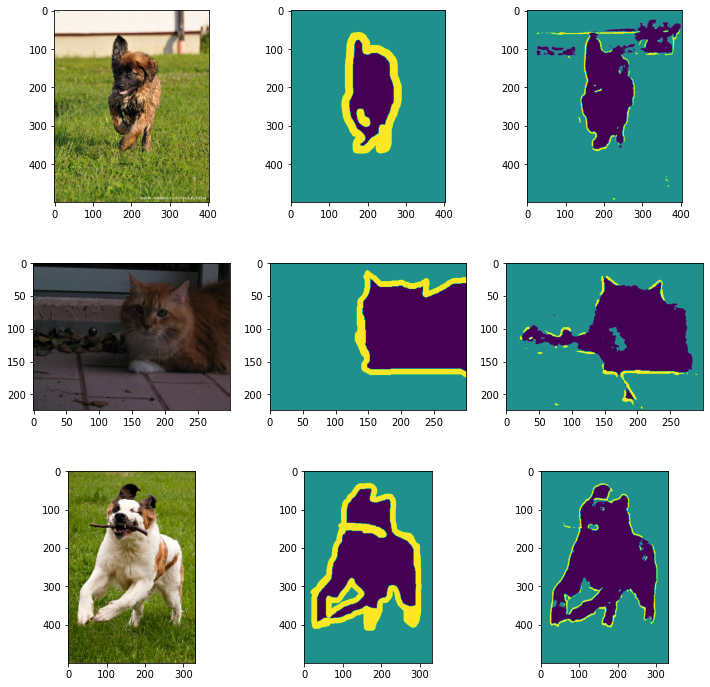

In [14]:
plt.figure(figsize = (12, 12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']
    
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask = mask - 1
    
    plt.subplot(3, 3, idx*3 + 1)
    plt.imshow(img)
    
    plt.subplot(3, 3, idx*3 + 2)
    plt.imshow(np.squeeze(mask, axis = 2))
    
    predict = tf.argmax(model.predict(tf.expand_dims(img, axis = 0)), axis = -1)
    plt.subplot(3, 3, idx*3 + 3)
    plt.imshow(np.squeeze(predict, axis = 0))

# 
# 
# 
# The End
# 
# 
# 